<h1>ABCD matrix simulation of a Josephson junction array</h1>
<h5>This notebook calculates the S-coefficients of a Josephson junction array with ray transfer matrix simulations.</h5>


<h3>Usage</h3>
To use this tool one must supply three information: the frequency range under consideration, the circuit to be simulated and the parameters of the circuit.

1. Circuit parameters - usually obtained from fabrication details or from experimental measurements.
2. Frequency range - the range which one wants to simulate, by default it goes from 1\,MHz to the plasma frequency of the array, but can be narrowed or extended.
3. Circuit - the 1D array to be considered is defined through a simple string, as is explained in the following.

Using these, it is possible to calculate the $S$-coefficients of the array starting from the matrices of its components. 
The code is based on a library of basic elements like resistances and capacitances, both in series or to ground, and some slightly more complicated ones, like RLC circuits which are used to approximate a Josephson junction. Several elements are already defined in the class <code>MatrixLibrary</code>, and if some others are required, they can be easily added to it. These elements are combined following the scheme defined by the circuit string, which is detailed later in this notebook. The actual calculations are performed by the function <code>array_abcd</code> contained in the class <code>ABCDMethods</code>, that multiplies all the elements in the right order, and returns the ray transfer matrix of the array. The matrix can then be analysed through the functions <code>s11</code>, <code>s21</code>,  <code>s12</code> and <code>s22</code> contained in the same class, which return the corresponding transmission or reflection spectrum.

<h4>Imports</h4>

In [1]:
import numpy as np

# plot and options
import matplotlib.pyplot as plt
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=14)

# loadbars
from tqdm.notebook import tqdm

# components library
from abcd_matrix import MatrixLibrary, ABCDMethods, ABCDUtils

# interactive plotting
#%matplotlib widget

<h2>Building the circuit</h2>


<h3>Definition of the parameters</h3>

First, one can define all the circuits' parameters, and then choose the working frequencies and the frequency points.

In [2]:
# circuit constants
# Value         Unit       What's that?

# array
Lj = 1.9e-9     # Henry    Inductance of one junction in the array
Cj = 95e-15     # Farad    Capacitance of one junction in the array
Rj = 1e6        # Ohm      Parallel resistance of one junction in the array
Cg = 1e-3*Cj    # Farad    Ground capacitance

# UJJ
Lu = 48.5e-9    # Henry    Inductance of the UJJ
Cu = 3.6e-15    # Farad    Capacitance of the UJJ
Ru = 1.0e5      # Ohm      Parallel resistance of the UJJ

# SSH
N_ssh = 7       #          Number of large junctions in one SSH period
n_ssh = 7       #          Number of small junctions in one SSH period
ssh_ratio = 3   #          Large to small ratio

# stuff in series
Rs = 1.0e4      # Ohm      Resistance in series with the UJJ
Cs = 10*Cj

# line
Rb = 50         # Ohm      Input and output resistors
Z0 = 50         # Ohm      Impedance on the lines

# disorder    
dis_on = False      #          Include asome disorder in the array's junctions
dis_par = 'array_junction_inductance'
dis_sigma = 0.1     #          Fractional amount of disorder to include in the array

Nj = 500        #          Number of junctions per side of the Bloch array 
                #          (not actually used, it needs to be specified when drawing the circuit)


# Defining a dictionary for the parameters, which afterwards can be updated without losing its first values
# you can add only the ones that you're actually using
parameters = { 'number_of_array_junctions': Nj,
               'array_junction_inductance': Lj, 
               'array_junction_capacitance': Cj,
               'array_junction_parallel_resistance': Rj,
               'array_junction_ground_capacitance': Cg,
               'ultrasmall_junction_inductance': Lu,
               'ultrasmall_junction_capacitance': Cu,
               'ultrasmall_junction_resistance': Ru,
               'ssh_period_N': N_ssh,
               'ssh_period_n': n_ssh,
               'ssh_junctions_ratio': ssh_ratio,
               'series_resistance': Rs,
               'series_capacitance': Cs,
               'line_resistance': Rb,
               'line_impedance': Z0,
               'add_disorder': dis_on,
               'disorder_parameter': dis_par,
               'disorder_sigma': dis_sigma
              }

In [3]:
ABCDUtils.show_array_properties(parameters)

Plasma frequency = 11.846 GHz
Critical current = 172.697 nA
Line impedance = 4.472 kOhm


<h3>Definition of the frequency range</h3>

In [4]:
# create the array of frequencies to be analysed

f_start = 1e6                            # start frequency
f_end = 1/(2*np.pi)/np.sqrt(Lj*Cj)-.1e9  # stop frequency (set just below the plasma)
n = 10001                                # number of frequency points

# frequency to omega
omega = 2*np.pi * np.linspace(f_start, f_end, n)

Calculating some useful parameters of the circuit

<h3>Definition of the circuit</h3>
The circuit is defined using a string that specifies the numer and type of component. 

Every circuit starts and ends with an impedance $Z_0$, which can be set in the circuit parameters. The string is connected to the input (port 1), so for example if the circuit is a simple resistance in series, the string will be <code style="color:firebrick">1Rs</code>, where <code>Rs</code> is the type of element, and <code>1</code> defines how many of them to put in series.
Different elements are separated by a space, so for example the string <code style="color:firebrick">1Cs 10Rs 1Cg</code>, creates a circuit with one capacitance in series with ten in-line resistances and a second capacitance to ground.

The parameters of the circuits components (capacitance, resistance and so on) are specified in the <code>parameters</code> dictionary.

Some example components present in the library are:
* <code>Rb</code>: input or output bias resistance
* <code>Cg</code>: capacitance to ground
* <code>J</code>: Josephson junction, which is an in-line LC and a capacitance Cg to ground
* <code>UJ</code>: ultrasmall junction, which is an RLC circuit
* <code>SSH</code>: one period of ssh modulation
* <code>Rs</code>: series resistance
* <code>Cs</code>: series capacitance
* <code>Sg</code>: short to ground
* <code>Og</code>: open to ground <br>
(Occhio, the component name is the same name given to the function in the library).

As an example, let's consider the following circuit:
<pre><code style="color:firebrick"> 1Cs 1Cg 500J 1UJ 1Cg 500J 1Cs </code></pre>
it defines an array with an in-line coupling capacitor, followed by one capacitor to ground, 500 Josephson junctions (which come with their own ground capacitance), one ultrasmall junction, followed by a ground capacitance, other 500 Josephson junctions and a last coupling capacitor. The scheme of the circuit is drawn hereafter.

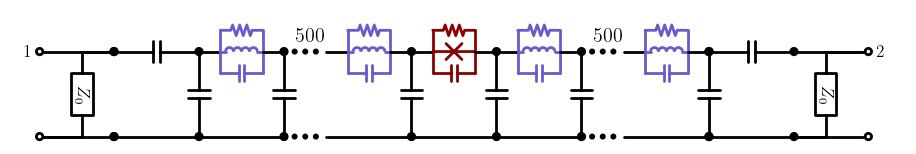

In [25]:
circuit = '1Cs 1Cg 500J 1UJ 1Cg 500J 1Cs'
ABCDUtils.draw_circuit(circuit, save_scheme=False) # you can save the drawing if you want

As just shown, one can also draw the circuit using the function <code>draw_circuit</code> in the class <code>ABCDUtils</code>.<br>
Please note that if you add a new element, it is important to add the drawing scheme as well, so that it is still possible to draw the circuit.
<br><br><br><br><br><br><br><br>

<h2>Example 1: $S_{21}(\omega)$ of an array with an ultrasmall junction in the middle (a.k.a. the Seb)</h2>
In this case we consider an array with two ports, galvanically connected through to the output impedance $Z_0$ through the bias resistances $R_b$.
Two superinductances (purple) enclose an ultrasmall junction (dark red) which acts as a coupler of the two halves. It is possible to calculate both the transmission and the reflection spectrum of this device.

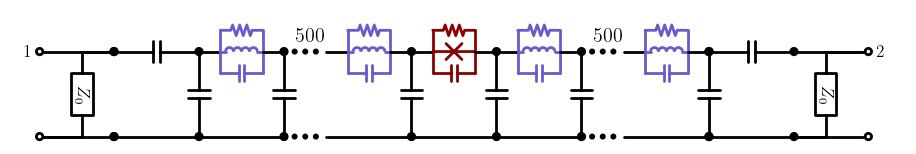

In [6]:
circuit = '1Cs 1Cg 500J 1UJ 1Cg 500J 1Cs'
ABCDUtils.draw_circuit(circuit) 

<h4>Computation of the circuit's matrix and spectrum</h4>
The following function shapes the input circuit with the chosen parameters.

In [7]:
# update one or more parameters (if you need to)
test_parameters = parameters.copy()

ultrasmall_junction_renormalization = 4
test_parameters.update({'ultrasmall_junction_inductance': ultrasmall_junction_renormalization*Lu})

In [8]:
# calculate the ABCD matrix
A = ABCDMethods.array_abcd(omega, circuit, test_parameters)

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
# extract the transmission spectrum
s21_db = ABCDMethods.s21(A, test_parameters, dB_out=True)
s21_phase = np.imag( ABCDMethods.s21(A, test_parameters) )

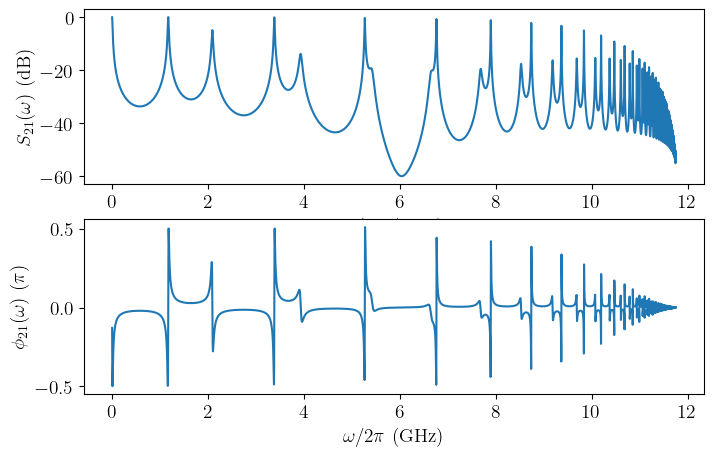

In [10]:
# plot
fig, ax = plt.subplots(2, 1, figsize=(8,5))
frequency_scale = 1e9

ax[0].plot(omega/2/np.pi/frequency_scale, s21_db)
ax[0].set_xlabel('$\omega/2\pi$ (GHz)')
ax[0].set_ylabel('$S_{21}(\omega)$ (dB)')

ax[1].plot(omega/2/np.pi/frequency_scale, s21_phase)
ax[1].set_xlabel('$\omega/2\pi$ (GHz)')
ax[1].set_ylabel('$\phi_{21}(\omega)$ ($\pi$)');

<h2>Example 2: $S_{11}(\omega)$ of an array with an ultrasmall junction at the end (a.k.a. the Dorian)</h2>
In this second example we consider a structure which practically is similar to a hanger resonator made of junctions. Just for fun we check the difference between adding an ultrasmall junction at the end or not. The coupling of these devices to the external world, $Z_0$, happens via a series capacitor $C_s$ connected to port 1, while there is an open to ground before port 2, making it actually useless. The open to ground can be switched to a short to ground to go from $\lambda/2$ to $\lambda/4$).

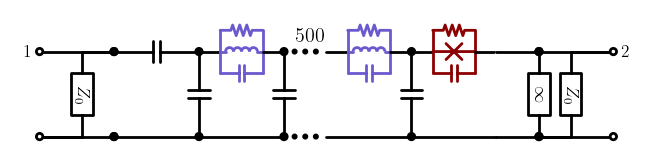

In [11]:
circuit_ujj = '1Cs 1Cg 500J 1UJ 1Og'
ABCDUtils.draw_circuit(circuit_ujj)

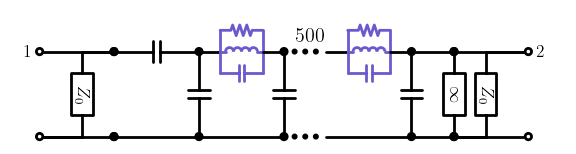

In [12]:
circuit_no_ujj = '1Cs 1Cg 500J 1Og'
ABCDUtils.draw_circuit(circuit_no_ujj)

<h4>Computation of the circuit's matrix and spectrum</h4>
The following function shapes the input circuit with the chosen parameters.

In [13]:
# update one or more parameters (if you need to)
test_parameters = parameters.copy()

ultrasmall_junction_renormalization = 4
test_parameters.update({'ultrasmall_junction_inductance': ultrasmall_junction_renormalization*Lu})

In [14]:
# calculate the ABCD matrix
A_ujj = ABCDMethods.array_abcd(omega, circuit_ujj, test_parameters)
A_no_ujj = ABCDMethods.array_abcd(omega, circuit_no_ujj, test_parameters)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
# extract the transmission spectrum
# first for the array with ultrasmall junction
s11_ujj_db = ABCDMethods.s11(A_ujj, test_parameters, dB_out=True)
s11_ujj_phase = np.imag( ABCDMethods.s11(A_ujj, test_parameters) )

# then for the array without ultrasmall junction
s11_no_ujj_db = ABCDMethods.s11(A_no_ujj, test_parameters, dB_out=True)
s11_no_ujj_phase = np.imag( ABCDMethods.s11(A_no_ujj, test_parameters) )

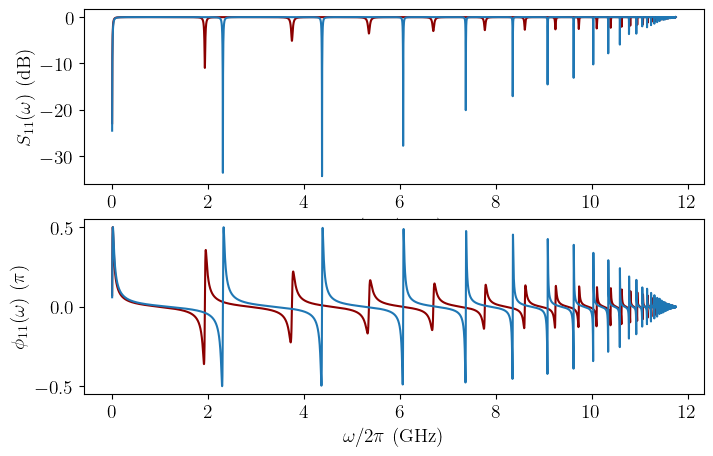

In [16]:
# plot
fig, ax = plt.subplots(2, 1, figsize=(8,5))
frequency_scale = 1e9

ax[0].plot(omega/2/np.pi/frequency_scale, s11_ujj_db, c='darkred')
ax[0].plot(omega/2/np.pi/frequency_scale, s11_no_ujj_db)
ax[0].set_xlabel('$\omega/2\pi$ (GHz)')
ax[0].set_ylabel('$S_{11}(\omega)$ (dB)')

ax[1].plot(omega/2/np.pi/frequency_scale, s11_ujj_phase, c='darkred')
ax[1].plot(omega/2/np.pi/frequency_scale, s11_no_ujj_phase)
ax[1].set_xlabel('$\omega/2\pi$ (GHz)')
ax[1].set_ylabel('$\phi_{11}(\omega)$ ($\pi$)');

<h2>Example 3: $S_{21}(\omega)$ of an SSH array (a.k.a. the Giulio)</h2>

This part is still a test. It implements an SSH array which has a symmetry-breaking part in the center, so while the SSH opens a gap in the transmission of the array, the defect in the middle adds a bound state at the center of the gap. The SSH element inherits the properties used for the array's junctions (for the large ones), and scales them by a numerical factor <code>ssh_ratio</code>, defined in the parameters dictionary.

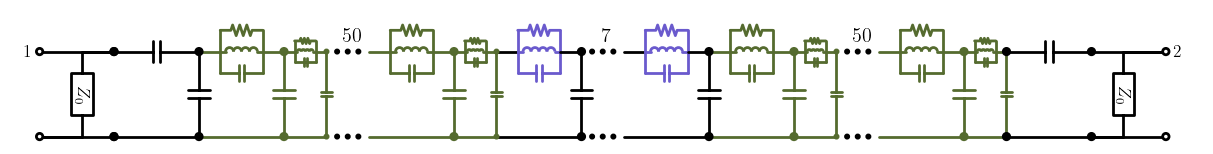

In [17]:
circuit = '1Cs 1Cg 50SSH 7J 50SSH 1Cs'
ABCDUtils.draw_circuit(circuit)

<h4>Computation of the circuit's matrix and spectrum</h4>
The following function shapes the input circuit with the chosen parameters.

In [18]:
# update one or more parameters (if you need to)
test_parameters = parameters.copy()
test_parameters.update({'array_junction_ground_capacitance': 50*Cg})

In [19]:
# calculate the ABCD matrix
A = ABCDMethods.array_abcd(omega, circuit, test_parameters)

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
# extract the transmission spectrum
s21_db = ABCDMethods.s21(A, test_parameters, dB_out=True)
s21_phase = np.imag( ABCDMethods.s21(A, test_parameters) )

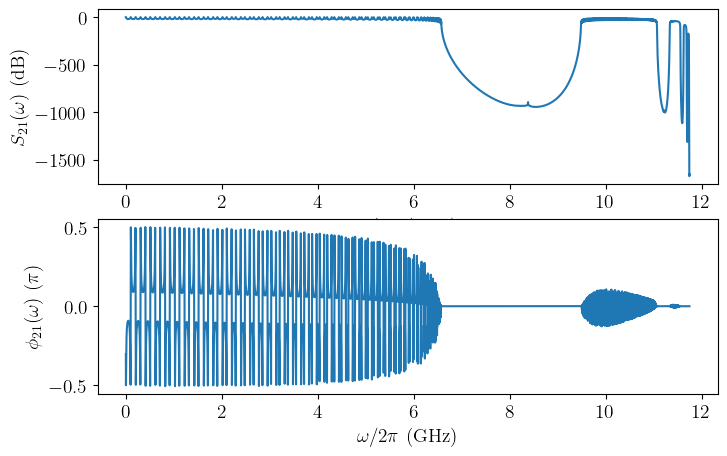

In [21]:
# plot
fig, ax = plt.subplots(2, 1, figsize=(8,5))
frequency_scale = 1e9

ax[0].plot(omega/2/np.pi/frequency_scale, s21_db)
ax[0].set_xlabel('$\omega/2\pi$ (GHz)')
ax[0].set_ylabel('$S_{21}(\omega)$ (dB)')

ax[1].plot(omega/2/np.pi/frequency_scale, s21_phase)
ax[1].set_xlabel('$\omega/2\pi$ (GHz)')
ax[1].set_ylabel('$\phi_{21}(\omega)$ ($\pi$)');

For example one can check what is the dependence of the gap on the ground capacitance.

In [22]:
# define the variation
variation_steps = 21
variation_size = 1

# linear
variation = np.linspace(-variation_size, variation_size, variation_steps)

# create a new dicionary for the parameters that will be varied
variation_parameters = parameters.copy()

In [23]:
# prepare the 2D array to be filled
s21_variation = np.zeros((variation_steps, n))

# compute the spectra corresponding to each variation point
for i in tqdm( range(variation_steps) ):
    
    ## definition of the variation type, 
    parameter = variation[i]     # linear variation
    #parameter = variation[i]**2  # quadratic variation
    
    # the variation increases the inductance of the ultrasmall junction
    variation_parameters.update({'array_junction_ground_capacitance': 50*Cg + (50*parameter * Cg)})
    
    # calculate the ABCD matrix and the spectrum
    A = ABCDMethods.array_abcd(omega, circuit, variation_parameters)
    s21_temp = ABCDMethods.s21(A, variation_parameters, dB_out=True)

    s21_variation[i,:] = s21_temp

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/ncr/Programmi/GitHub/Neel/simulation_scripts/ABCD_matrix_simulations/abcd_matrix.py:216: RuntimeWarning: overflow encountered in multiply
  ABCD = np.matmul(ABCD, component(omega, parameters))
/Users/ncr/Programmi/GitHub/Neel/simulation_scripts/ABCD_matrix_simulations/abcd_matrix.py:216: RuntimeWarning: invalid value encountered in add
  ABCD = np.matmul(ABCD, component(omega, parameters))
/Users/ncr/Programmi/GitHub/Neel/simulation_scripts/ABCD_matrix_simulations/abcd_matrix.py:216: RuntimeWarning: invalid value encountered in matmul
  ABCD = np.matmul(ABCD, component(omega, parameters))
/Users/ncr/Programmi/GitHub/Neel/simulation_scripts/ABCD_matrix_simulations/abcd_matrix.py:216: RuntimeWarning: invalid value encountered in multiply
  ABCD = np.matmul(ABCD, component(omega, parameters))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

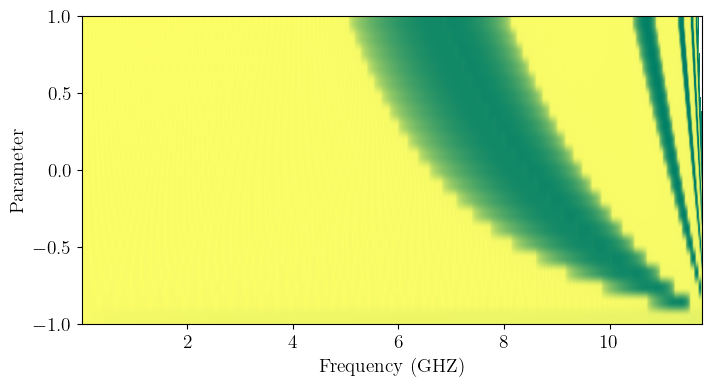

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
frequency_scale = 1e9

ax.imshow( s21_variation, aspect='auto', origin='lower', cmap='summer', vmin = -1000,
            extent=(f_start/frequency_scale, f_end/frequency_scale, variation[0], variation[-1]) )

ax.set_xlabel('Frequency (GHZ)')
ax.set_ylabel('Parameter');